In [1]:

import sys
import numpy as np
import pandas as pd
import pygeohydro as gh
from pygeohydro import NWIS
import matplotlib.pyplot as plt

sys.path.append('../')

import sglib as sg
from sglib.verification.drought import get_drought_metrics, calculate_ssi_values
from sglib.utils.load import load_drb_reconstruction

from sglib.plotting.plot import plot_autocorrelation, plot_fdc_ranges, plot_flow_ranges
from sglib.plotting.drought import drought_metric_scatter_plot

from sglib.methods.nonparametric.kirsch_nowak import KirschNowakGenerator
from sglib.utils.load import HDF5
from sglib.droughts.ssi import SSIDroughtMetrics

In [2]:
Q = load_drb_reconstruction()
print(f"Loaded reconstruction data with {Q.shape[0]// 365} years of daily data for {Q.shape[1]} sites.")

Q_monthly = Q.resample('MS').sum()


Loaded reconstruction data with 79 years of daily data for 30 sites.


In [3]:
# Initialize the generator
kn_gen = KirschNowakGenerator(Q, debug=False)

# Preprocess the data
kn_gen.preprocessing()

# Fit the model
kn_gen.fit()

# Generate 10 years
n_years = 79
n_realizations = 50
m_draw = kn_gen._get_bootstrap_indices(n_years=n_years+1)
synthetic_series = kn_gen.generate_single_series(n_years=n_years, 
                                                 M=m_draw)

syn_ensemble = kn_gen.generate(n_realizations=n_realizations, 
                               n_years=n_years, 
                               as_array=False)

In [4]:
# Format syntehtic ensemble to format 

Q_syn = {}
site_ensemble = np.zeros((n_years*12, n_realizations), 
                 dtype=float)
for site in Q.columns:
    Q_syn[site] = np.zeros((n_years*12, n_realizations),
                 dtype=float)
    
    for i in range(n_realizations):
        Q_syn[site][:, i] = syn_ensemble[i][site].values 
        
    # Convert to DataFrame
    Q_syn[site] = pd.DataFrame(Q_syn[site], 
                               index=Q_monthly.index, 
                               columns=[i for i in range(n_realizations)])


# Q_syn['cannonsville']

In [5]:
SSI = SSIDroughtMetrics(timescale='M', window=12)
ssi = SSI.calculate_ssi(data=syn_ensemble[0].iloc[:, 0])
droughts = SSI.calculate_drought_metrics(ssi)
print(f'Syn Droughts: {droughts}')


SSI = SSIDroughtMetrics(timescale='M', window=12)
ssi_obs = SSI.calculate_ssi(data=Q_monthly)


Syn Droughts:                   start                  end duration  magnitude  severity
1   2025-12-01 00:00:00  2030-11-01 00:00:00       60 -59.282324 -8.084317
2   2033-12-01 00:00:00  2037-02-01 00:00:00       39  -58.92172 -7.907139
3   2041-12-01 00:00:00  2045-10-01 00:00:00       47 -48.852369 -7.976618
4   2049-01-01 00:00:00  2051-06-01 00:00:00       30 -28.444488 -3.179872
5   2055-05-01 00:00:00  2056-03-01 00:00:00       11   -7.05154 -1.094977
6   2058-12-01 00:00:00  2060-12-01 00:00:00       25 -14.398328 -1.452369
7   2068-12-01 00:00:00  2070-11-01 00:00:00       24 -22.884605 -1.549637
8   2078-01-01 00:00:00  2079-06-01 00:00:00       18 -15.602796 -1.631783
9   2081-08-01 00:00:00  2084-11-01 00:00:00       40 -27.347854 -1.142908
10  2085-12-01 00:00:00  2087-05-01 00:00:00       18 -12.408741 -1.150657
11  2090-03-01 00:00:00  2090-12-01 00:00:00       10 -22.962638 -7.997098


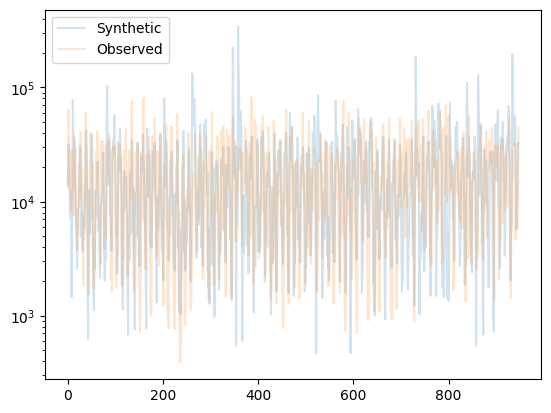

In [15]:
plt.plot(syn_ensemble[0].values[:, 0], alpha=0.2, label='Synthetic')
plt.plot(Q_monthly.values[:, 0], alpha=0.2, label='Observed')
plt.legend()
plt.yscale('log')

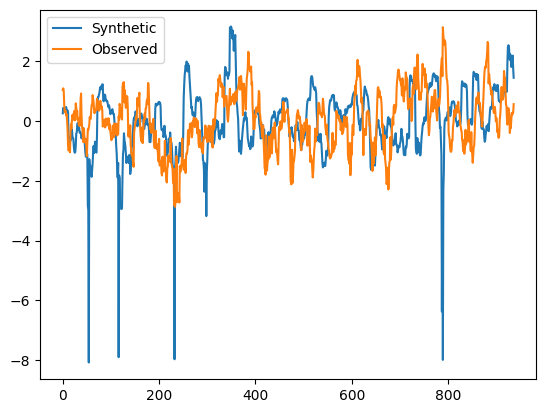

In [7]:
plt.plot(ssi.values, label='Synthetic')
plt.plot(ssi_obs.values, label='Observed')
plt.legend()

In [19]:
syn_ensemble[0].rolling(window=12).sum().dropna().values[:, 0].min()

93117.93629542406

In [ ]:
# get abs and syn autocorrelation
lags = np.arange(1, 13)
obs_acf = np.zeros(lags.shape[0])
syn_acf = np.zeros(lags.shape[0])
for i, lag in enumerate(lags):
    obs_acf[i] = np.corrcoef(Q_monthly.iloc[:, 0].values[:-lag], Q_monthly.iloc[:, 0].values[lag:])[0, 1]
    syn_acf[i] = np.corrcoef(syn_ensemble[4].iloc[:, 0].values[:-lag], syn_ensemble[4].iloc[:, 0].values[lag:])[0, 1]


array([[1.        , 0.49934197],
       [0.49934197, 1.        ]])

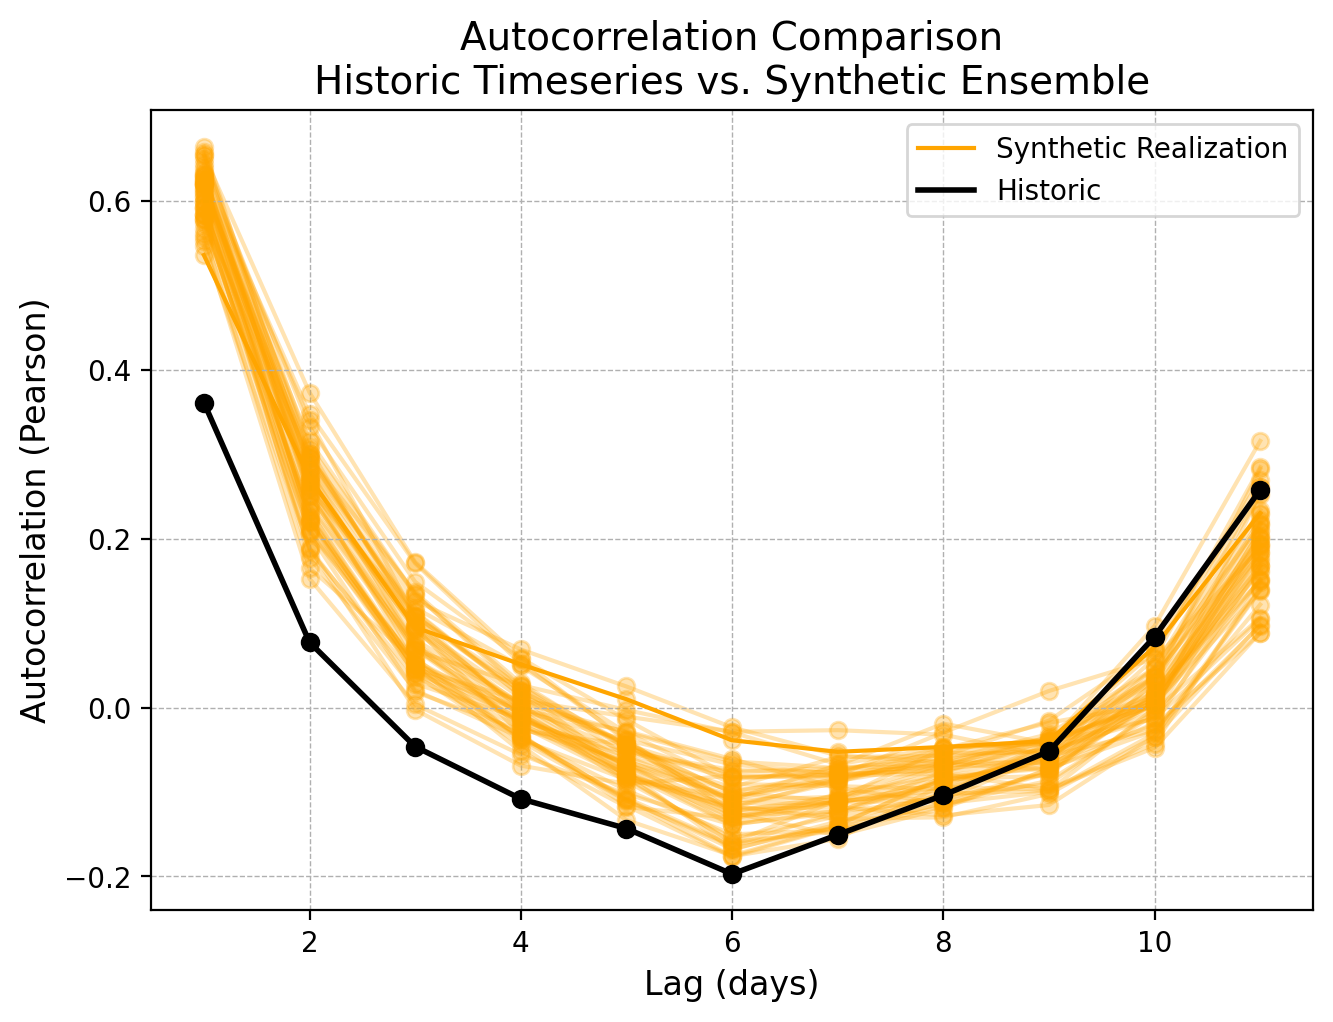

xs: Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int32') 

 s_min: 1      1334.591669
2      1693.999292
3      9248.355387
4     11604.150524
5      4105.234683
6      1815.058007
7       570.060037
8       357.664777
9       496.544134
10      271.907956
11      998.820361
12     1359.434392
dtype: float64 




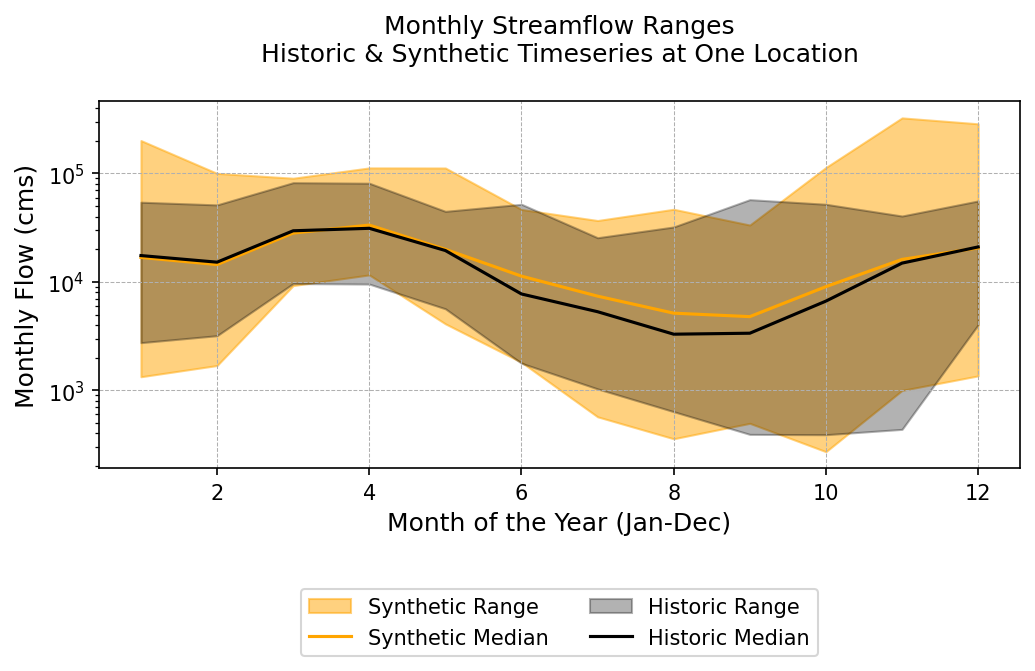

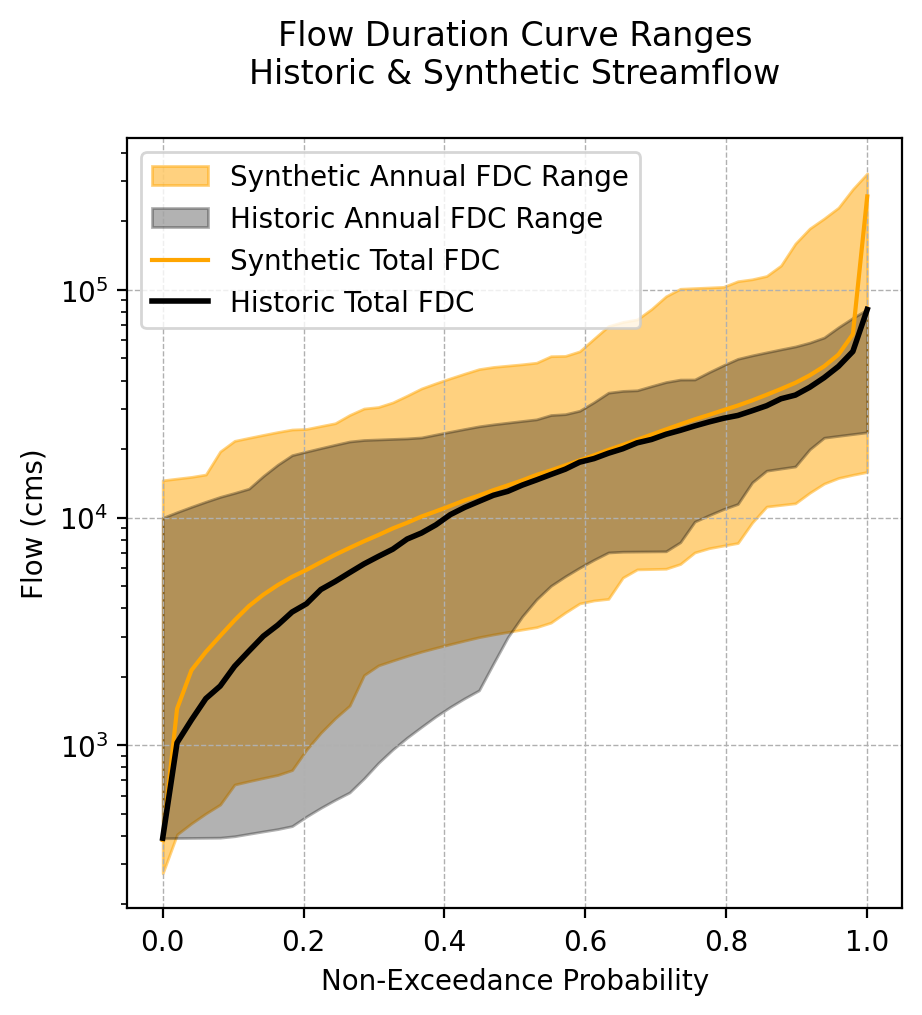

In [11]:
plot_site = 'pepacton'

plot_autocorrelation(Q_monthly.loc[:, plot_site], 
                     Q_syn[plot_site], 
                     lag_range=np.arange(1,12), timestep='daily')

plot_flow_ranges(Q_monthly.iloc[:,0], Q_syn[plot_site], 
                 timestep='monthly')

plot_fdc_ranges(Q_monthly.iloc[:,0], Q_syn[plot_site])
